<a href="https://colab.research.google.com/github/phongvu009/NLP_WaveNet/blob/main/NLP_MakeMore_WaveNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.__version__

'2.0.1+cu118'

In [33]:
import pdb;

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-08-09 15:01:31--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-08-09 15:01:32 (8.08 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
#open file
words = open('names.txt', mode='r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
#Create a list a unique character
alphabets = sorted(list(set(''.join(words))))

#A dict: character to index
stoi = {char: idx+1 for idx , char in enumerate(alphabets) }
#Add dot character
stoi['.'] = 0

#A dict: index to character
itos =  {idx:char for char,idx in stoi.items() }
print(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset

In [6]:
#shuffle words
import random
random.seed(42)
random.shuffle(words)

In [7]:
block_size = 8
def build_dataset(words):
  X,Y = [],[]
  for word in words:
    #start with 0
    context = [0] * block_size
    for char in word + '.':
      #get index
      idx = stoi[char]
      X.append(context)
      Y.append(idx)
      #update context
      context = context[1:] + [idx]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape , Y.shape)
  return X,Y

In [8]:
#get index number to divide the data
n_1 = int(0.8*len(words))
print(n_1)

n_2 = int(0.9*len(words))
print(n_2)

25626
28829


In [9]:
# 80% data for Training
X_train, Y_train = build_dataset(words[:n_1])

# 10% data for Validation
X_dev, Y_dev = build_dataset(words[n_1:n_2])

# 10% data for Testing
X_test, Y_test = build_dataset(words[n_2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [10]:
#Example of some data for training
for x,y in zip(X_train[:10],Y_train[:10]):
  print( f' {[itos[xi.item()] for xi in x]} --- {itos[y.item()]}')


 ['.', '.', '.', '.', '.', '.', '.', '.'] --- y
 ['.', '.', '.', '.', '.', '.', '.', 'y'] --- u
 ['.', '.', '.', '.', '.', '.', 'y', 'u'] --- h
 ['.', '.', '.', '.', '.', 'y', 'u', 'h'] --- e
 ['.', '.', '.', '.', 'y', 'u', 'h', 'e'] --- n
 ['.', '.', '.', 'y', 'u', 'h', 'e', 'n'] --- g
 ['.', '.', 'y', 'u', 'h', 'e', 'n', 'g'] --- .
 ['.', '.', '.', '.', '.', '.', '.', '.'] --- d
 ['.', '.', '.', '.', '.', '.', '.', 'd'] --- i
 ['.', '.', '.', '.', '.', '.', 'd', 'i'] --- o


## Pre_Training

In [11]:
class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [12]:
class BatchNorm1d:
  def __init__(self, dim, eps = 1e-3, momentum =0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #param to shift,scale the bell curve
    self.gamma =  torch.ones(dim)
    self.beta  = torch.zeros(dim)
    #buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      #check the dimension to get correct mean and var
      if x.ndim == 2 :
        xdim = 0
      if x.ndim == 3 :
        xdim = (0,1)
      #get the mean,std for the whole batch
      xmean = x.mean(xdim , keepdim=True)
      xvar = x.var(xdim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps) #normalize Unit
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = ( 1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

In [13]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in,fan_out)
    self.bias = torch.randn(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ( [] if self.bias is None else [self.bias])

In [14]:
class Embedding:
  def __init__(self, num_embedding , num_dim):
    self.weight = torch.randn((num_embedding,num_dim)) #Create matrix weight

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out # return tensor

  def parameters(self):
    return [self.weight]

In [15]:
class FlattenConsecutive:
  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B, T, C = x.shape #get the shape of the batch
    x = x.view(B, T//self.n , self.n*C) # instead of 1 data , pairs of 2 data will be fed in
    if x.shape[1] == 1: # if batch has shape [N,1,:]
      x = x.squeeze(dim=1)
    self.out = x  # keep track the output by using self.out
    return self.out

  def parameters(self):
    return []

In [16]:
class Sequential:
  def __init__(self,layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

## Training

In [17]:
torch.manual_seed(42)

In [18]:
n_embd = 10
n_hidden = 200
vocab_size = len(itos)

In [19]:
model = Sequential([
    Embedding( vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2 , n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2 , n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2 , n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear( n_hidden , vocab_size)
])

In [20]:
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer is less confident

params = model.parameters()
print(sum( e.nelement() for e in params))

170897


In [21]:
#Require tracking gradient
for p in model.parameters():
  p.requires_grad = True

In [22]:
max_steps = 200000
batch_size = 32
lossi = []

In [23]:
for i in range(max_steps):
  #Construct mini-batch
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb,Yb = X_train[ix] , Y_train[ix]
  #Forward Pass
  logits = model(Xb)
  #---- As same as : F.cross.entropy -------
  logits_maxes = logits.max(1,keepdim=True).values
  norm_logits = logits - logits_maxes #subtract the max
  counts = norm_logits.exp()
  counts_sum = counts.sum(1,keepdim=True)
  counts_sum_inv = counts_sum**-1 # same as 1/counts_sum
  probs = counts * counts_sum_inv # do elementwise
  logprobs = probs.log()
  loss = -logprobs[range(batch_size),Yb].mean()
  #print(loss == F.cross_entropy(logits, Yb))
  #---- As same as : F.cross.entropy -------
  #Backward Pass
  for p in model.parameters():
    p.grad = None # reset gradients
  loss.backward() # calculate gradients
  lr = 0.1 if i < 150000 else 0.01 # learning weight decay
  for p in model.parameters(): # update gradients
    p.data += -lr * p.grad


  # Track stats
  if i % 10000 == 0:
    print(f'{i:6d}/{max_steps:6d} ---- {loss.item():.4f}')
  lossi.append(loss.log10().item())


     0/200000 ---- 4.0110
 10000/200000 ---- 1.8662
 20000/200000 ---- 2.1649
 30000/200000 ---- 1.9902
 40000/200000 ---- 2.2596
 50000/200000 ---- 2.0849
 60000/200000 ---- 1.9144
 70000/200000 ---- 2.1569
 80000/200000 ---- 2.6884
 90000/200000 ---- 2.2133
100000/200000 ---- 2.3229
110000/200000 ---- 1.9768
120000/200000 ---- 1.8715
130000/200000 ---- 2.0714
140000/200000 ---- 1.7534
150000/200000 ---- 1.9747
160000/200000 ---- 1.9094
170000/200000 ---- 1.8352
180000/200000 ---- 2.3406
190000/200000 ---- 2.2956


In [24]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


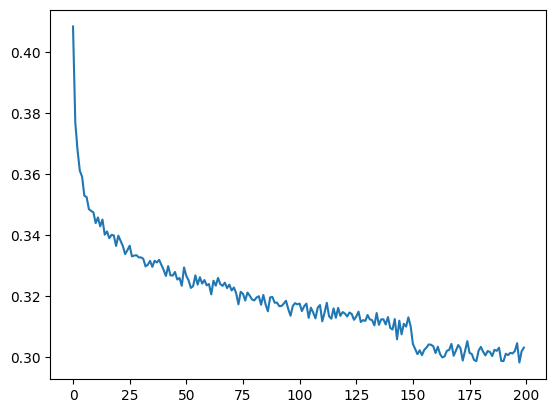

In [25]:
interval = torch.tensor(lossi).view(-1,1000).mean(1)
plt.plot(interval)

## Evaluation

In [26]:
#set eval mode
for layer in model.layers:
  layer.training = False

In [27]:
#Evaluate  Loss
@torch.no_grad()
def stage(data_stage):
  x,y = {
      'train': (X_train, Y_train),
      'val' : (X_dev,Y_dev),
      'test' : (X_test,Y_test)
  }[data_stage]
  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(data_stage, loss.item())

In [28]:
stage('train')
stage('val')

train 1.9742501974105835
val 2.0475003719329834


## Get Sample From Training Model

In [43]:
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    #Forwardpass the network
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    #update context
    context = context[1:] + [ix]
    out.append(ix)
    #if dot in sample
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


raeda.
brilyn.
lynne.
marion.
taiden.
jene.
saygan.
a.
feston.
aylanian.
annaliei.
luhb.
teot.
nenmhhon.
nazanta.
cellery.
ameniha.
macaryna.
korriyah.
areya.
